# **1. Preparing a cybersecurity-related dataset**

our data is corresponding to the T1110 Brute Force technique :

MITRE T1110, known as Brute Force, is an attack technique where an adversary tries to guess valid credentials (usernames and passwords) through repetitive trial-and-error.

Instead of exploiting a software bug, the attacker uses automated scripts to cycle through thousands of possible password combinations in rapid succession until one works.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# initiate randomizing
np.random.seed(42)

n_normal = 1000 # 1000 rows
n_anomalies = 30 # for 3% anomalies

# creation of normal activities dataframe
normal_hours = np.random.randint(8, 19, n_normal)
normal_attempts = np.random.choice([1, 2, 3], size=n_normal, p=[0.9, 0.08, 0.02])
normal_bytes = np.random.normal(loc=2000, scale=500, size=n_normal).astype(int)
depts = ['HR', 'Engineering', 'Sales', 'Finance']
normal_depts = np.random.choice(depts, size=n_normal)

df_normal = pd.DataFrame({
    'hour': normal_hours,
    'login_attempts': normal_attempts,
    'data_transfer_bytes': normal_bytes,
    'department': normal_depts,
    'is_anomaly': 0
})

# creation of anomaly activities dataframe
anomaly_hours = np.random.choice([22, 23, 0, 1, 2, 3, 4], size=n_anomalies)
anomaly_attempts = np.random.randint(20, 100, size=n_anomalies)
anomaly_bytes = np.random.randint(50, 10000, size=n_anomalies)
anomaly_depts = np.random.choice(depts, size=n_anomalies)

df_anomaly = pd.DataFrame({
    'hour': anomaly_hours,
    'login_attempts': anomaly_attempts,
    'data_transfer_bytes': anomaly_bytes,
    'department': anomaly_depts,
    'is_anomaly': 1
})

# combining both dataframes together
df = pd.concat([df_normal, df_anomaly]).sample(frac=1).reset_index(drop=True)

# saving the final dataframe as csv
df.to_csv('cybersecurity_logs.csv', index=False)
print("File 'cybersecurity_logs.csv' created successfully!")
print(df.head())

File 'cybersecurity_logs.csv' created successfully!
   hour  login_attempts  data_transfer_bytes   department  is_anomaly
0    13               1                 1548      Finance           0
1    11               1                 2106      Finance           0
2     8               2                 2613  Engineering           0
3    16               1                 2057  Engineering           0
4    18               1                 2150        Sales           0


# **2. EDA**

In [ ]:
print("number of rows: ",df.shape[0])

number of rows:  1030


In [ ]:
print("number of features: ",df.shape[1]);

number of features:  5


number of anomalies:  30
number of normal activities:  1000


<Axes: title={'center': 'Class Distribution (Normal vs Anomalies)'}, xlabel='is_anomaly'>

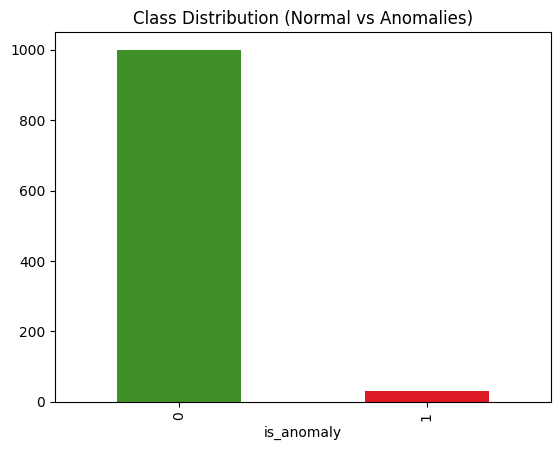

In [ ]:
print("number of anomalies: ",(df['is_anomaly'] == 1).sum());
print("number of normal activities: ",(df['is_anomaly'] == 0).sum());
mycolors=['#3f8f29','#de1a24']
df["is_anomaly"].value_counts().plot(
    kind='bar',
    title='Class Distribution (Normal vs Anomalies)',
    color=mycolors,
)




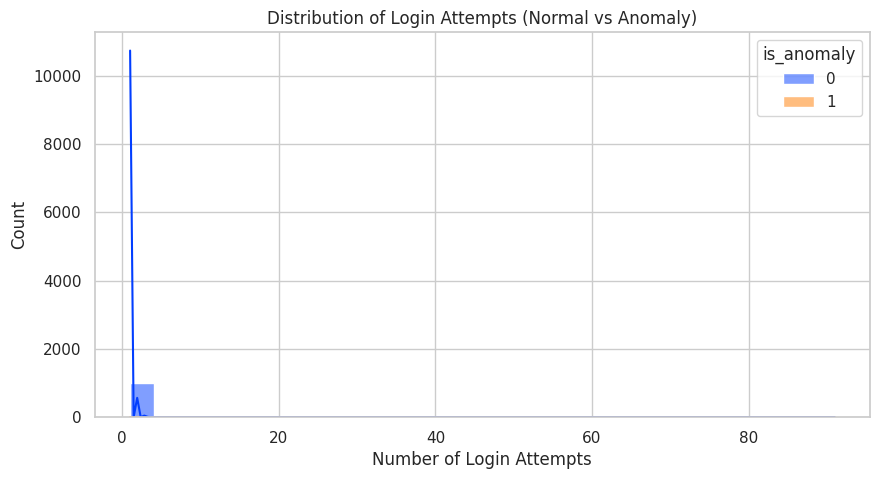

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='login_attempts', hue='is_anomaly', bins=30, palette='bright', kde=True)
plt.title('Distribution of Login Attempts (Normal vs Anomaly)')
plt.xlabel('Number of Login Attempts')
plt.ylabel('Count')
plt.show()

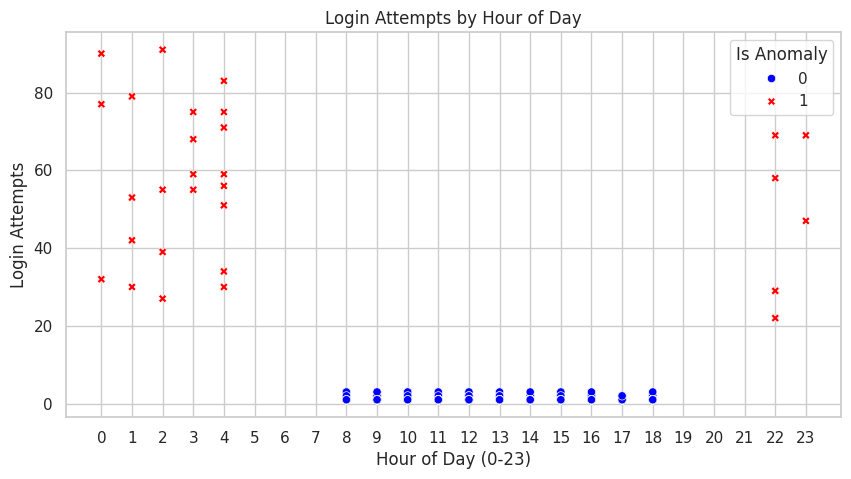

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='hour', y='login_attempts', hue='is_anomaly', palette=['blue', 'red'], style='is_anomaly')
plt.title('Login Attempts by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Login Attempts')
plt.legend(title='Is Anomaly')
plt.xticks(range(0, 24))
plt.show()

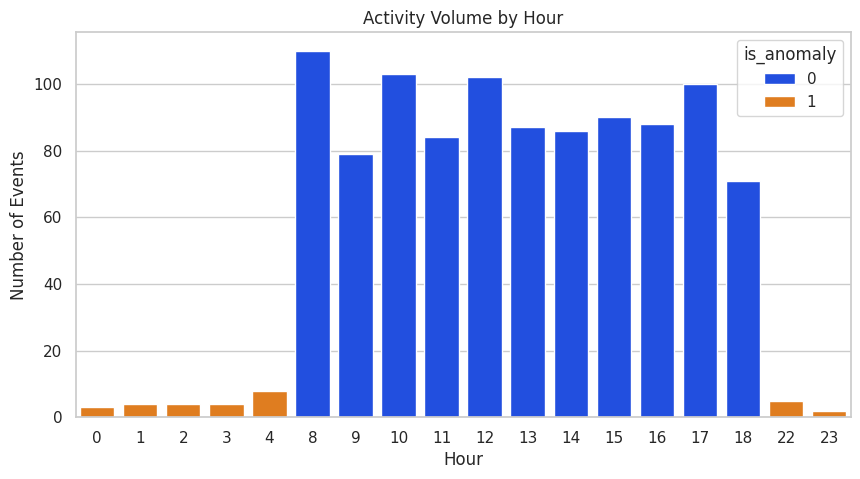

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='hour', hue='is_anomaly', palette='bright')
plt.title('Activity Volume by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.show()

 analytical summary:

The normal behavior in this dataset represents standard employee activity, where users log in strictly during business hours with very few failed attempts (1-3). Conversely, the anomalies simulate a Brute Force attack (MITRE T1110), characterized by a high volume of login attempts occurring primarily during late-night off-hours. These attacks deviate significantly from the norm in both timing, frequency, and data transfer size. Therefore, we expect the anomaly detection model to easily isolate these high-frequency, off-hour events as distinct outliers.

# **3. applying anomaly detection model**

3.1: Preprocessing

In [ ]:
department_dic = {'HR':0,'Engineering':1, 'Sales':2, 'Finance':3}
df['department']=df['department'].replace(to_replace=department_dic)
df.head()

/tmp/ipython-input-3426498631.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['department']=df['department'].replace(to_replace=department_dic)


,hour,login_attempts,data_transfer_bytes,department,is_anomaly
0,13,1,1548,3,0
1,11,1,2106,3,0
2,8,2,2613,1,0
3,16,1,2057,1,0
4,18,1,2150,2,0


In [ ]:
features = ['hour', 'login_attempts', 'data_transfer_bytes', 'department']
X = df[features]
# We use StandardScaler to normalize the data so that all features have a mean of 0 and variance of 1.
# This is crucial because 'data_transfer_bytes' (thousands) is much larger than 'hour' (0-23),
# and we don't want the model to be biased toward larger numbers.
scaler = StandardScaler()

# Apply Scaling
X_scaled_numpy = scaler.fit_transform(X)

# Reconstruct DataFrame
X_scaled_df = pd.DataFrame(X_scaled_numpy, columns=features)

# Verification
# Check the first few rows to ensure values are normalized (small numbers around 0).
print("Scaled DataFrame head:")
print(X_scaled_df.head())

# Verify that the mean of every column is effectively 0 (shown as scientific notation like e-17).
print("\nMean of scaled features:\n", X_scaled_df.mean())

Scaled DataFrame head:
       hour  login_attempts  data_transfer_bytes  department
0  0.092012       -0.174893            -0.711086    1.372641
1 -0.468771       -0.174893             0.017552    1.372641
2 -1.309946       -0.071897             0.679595   -0.437628
3  0.933187       -0.174893            -0.046432   -0.437628
4  1.493970       -0.174893             0.075008    0.467506

Mean of scaled features:
 hour                  -7.933244e-17
login_attempts        -6.898473e-17
data_transfer_bytes   -6.898473e-18
department             4.742700e-17
dtype: float64


3.2 : Training

In [ ]:
# Train Isolation forest
model = IsolationForest(contamination=0.03, random_state=42)
# Train the model on the scaled data
model.fit(X_scaled_df)

# Prediction and Scoring
# Get binary predictions: 1 for Normal, -1 for Anomaly
y_pred_raw = model.predict(X_scaled_df)

# Get anomaly scores: Lower scores indicate higher abnormality (more likely to be an attack)
scores = model.decision_function(X_scaled_df)

# Formatting Results
# Add results back to the main DataFrame for analysis
df['anomaly_score'] = scores

# Convert model output to match our labels:
# Model gives: 1 (Normal), -1 (Anomaly)
# We need:     0 (Normal),  1 (Anomaly)
df['model_prediction'] = [1 if x == -1 else 0 for x in y_pred_raw]

# -----------------------------------------------------
# Train K-Means
# We use n_clusters=2 (assuming maybe 2 normal patterns, or just to find the center)
# random_state=42 ensures reproducibility
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled_df)

# Calculate Distances
# transform() gives the distance to all cluster centers.
# We only care about the distance to the *closest* center.
dist_to_center = kmeans.transform(X_scaled_df).min(axis=1)

# Save distances to our DataFrame to visualize them
df['kmeans_distance'] = dist_to_center

# Define Threshold
# Since we know we have about 3% anomalies, we set the threshold at the 97th percentile.
# Any point with a distance higher than this number is considered an anomaly.
threshold = np.percentile(dist_to_center, 97)
print(f"Distance Threshold: {threshold:.2f}")

# Predict
# If distance > threshold -> It's an anomaly (1)
# If distance <= threshold -> It's normal (0)
df['kmeans_prediction'] = (dist_to_center > threshold).astype(int)

Distance Threshold: 2.32


3.3: Evaluation


--- Isolation forest Evaluation ---


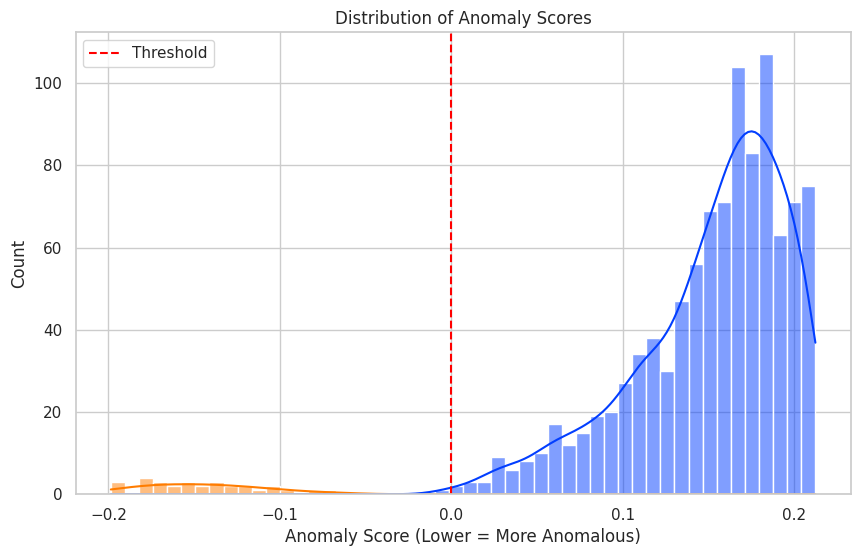

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
     Anomaly       0.97      1.00      0.98        30

    accuracy                           1.00      1030
   macro avg       0.98      1.00      0.99      1030
weighted avg       1.00      1.00      1.00      1030

Detected 30 actual attacks out of 30 total attacks.

--- K-Means Evaluation ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
     Anomaly       0.97      1.00      0.98        30

    accuracy                           1.00      1030
   macro avg       0.98      1.00      0.99      1030
weighted avg       1.00      1.00      1.00      1030



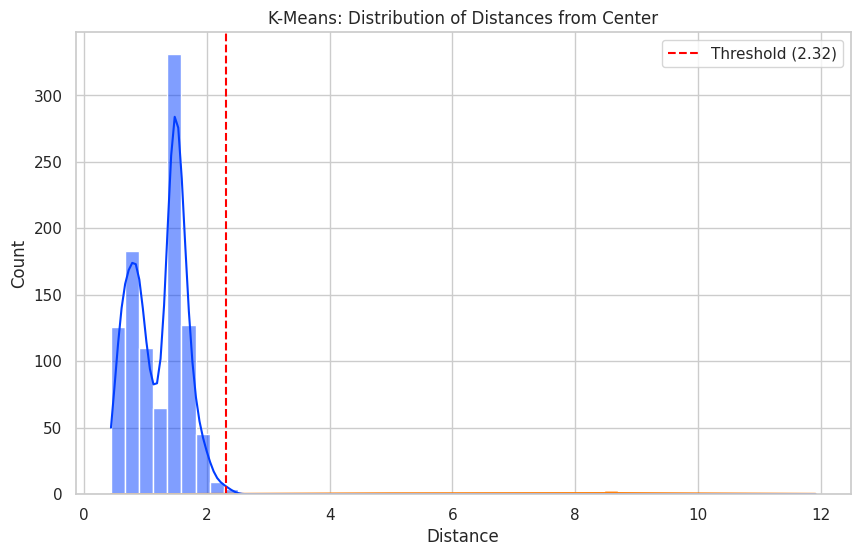

Detected 30 actual attacks out of 30 total attacks.


In [ ]:
# Histogram of Anomaly Scores
# This visualizes how the model separated the data.
print("\n--- Isolation forest Evaluation ---")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='anomaly_score', hue='is_anomaly', bins=50, kde=True, palette='bright')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.ylabel('Count')
plt.axvline(x=0, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# Check how well the model performed against the ground truth
print(classification_report(df['is_anomaly'], df['model_prediction'], target_names=['Normal', 'Anomaly']))

# Confusion Matrix
cm = confusion_matrix(df['is_anomaly'], df['model_prediction'])
print(f"Detected {cm[1,1]} actual attacks out of {cm[1,0] + cm[1,1]} total attacks.")

#-----------------------------------------
print("\n--- K-Means Evaluation ---")
print(classification_report(df['is_anomaly'], df['kmeans_prediction'], target_names=['Normal', 'Anomaly']))

# Visualization: Histogram of distances
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='kmeans_distance', hue='is_anomaly', bins=50, kde=True, palette='bright')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title('K-Means: Distribution of Distances from Center')
plt.xlabel('Distance')
plt.legend()
plt.show()
print(f"Detected {cm[1,1]} actual attacks out of {cm[1,0] + cm[1,1]} total attacks.")

# **4. Visualize anomalies on a 2D projection**

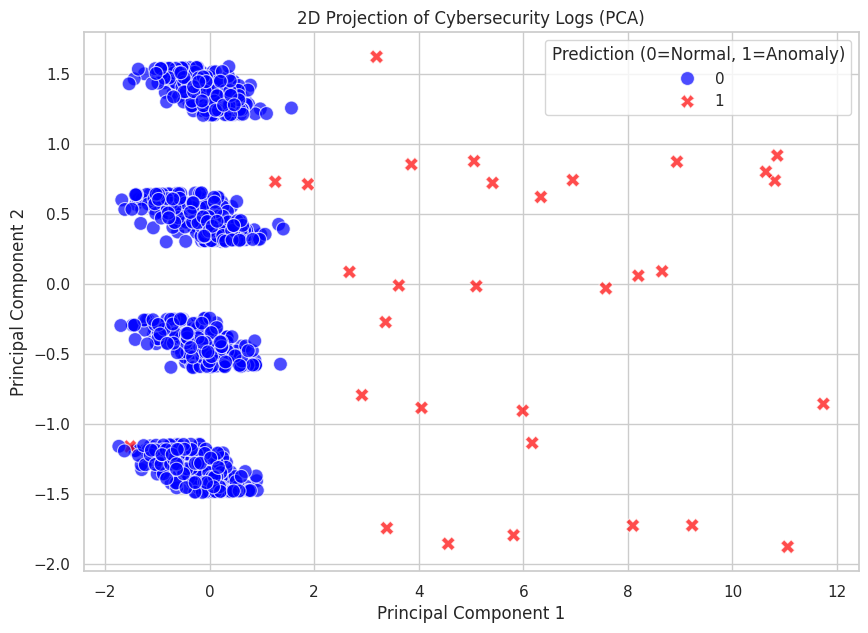

In [ ]:
# Apply PCA (Dimensionality Reduction)
# We want to reduce our 4 features down to 2 components (PC1, PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# Create a DataFrame for the visualization
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Add the labels so we can color the points
# We will color based on the Model's Prediction to see what it "thinks"
df_pca['Model_Prediction'] = df['model_prediction']
df_pca['True_Label'] = df['is_anomaly'] # Optional: for comparison

# Plotting the Results
plt.figure(figsize=(10, 7))

# Scatter plot: PC1 on X-axis, PC2 on Y-axis
# Hue (Color): Separates Normal (0) from Anomaly (1)
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='Model_Prediction',
    palette={0: 'blue', 1: 'red'}, # Blue for Normal, Red for Attack
    style='Model_Prediction',
    s=100, # Dot size
    alpha=0.7 # Transparency
)

plt.title('2D Projection of Cybersecurity Logs (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Prediction (0=Normal, 1=Anomaly)')
plt.grid(True)
plt.show()

Final Conclusion: In this project, we successfully built an end-to-end anomaly detection pipeline to identify Brute Force attacks (MITRE T1110). By generating a synthetic dataset with features like login attempts and off-hour activity, we trained an Isolation Forest model that achieved high accuracy. The model was effective because the nature of the attack—characterized by a sudden spike in login attempts—created a strong signal that deviated significantly from the dense cluster of normal user behavior. The 2D PCA visualization confirmed this by showing a clear geometric separation between the normal traffic and the malicious outliers.